In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_pickle("data/clean_data/LoL_full_data_filtered.pkl")

data = df.TXT.values.tolist()

In [3]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['disturbance', 'legacies', 'and', 'climate', 'jointly', 'drive', 'tree', 'growth', 'and', 'mortality', 'in', 'an', 'intensively', 'studied', 'boreal', 'forest', 'boreal', 'forest', 'carbon', 'cycling', 'climate', 'change', 'dendrology', 'disturbance', 'forest', 'mortality', 'machine', 'learning', 'most', 'north', 'american', 'forests', 'are', 'at', 'some', 'stage', 'of', 'post', 'disturbance', 'regrowth', 'subject', 'to', 'changing', 'climate', 'and', 'exhibit', 'growth', 'and', 'mortality', 'patterns', 'that', 'may', 'not', 'be', 'closely', 'coupled', 'to', 'annual', 'environmental', 'conditions', 'distinguishing', 'the', 'possibly', 'interacting', 'effects', 'of', 'these', 'processes', 'is', 'necessary', 'to', 'put', 'short', 'term', 'studies', 'in', 'longer', 'term', 'context', 'and', 'particularly', 'important', 'for', 'the', 'carbon', 'dense', 'fire', 'prone', 'boreal', 'forest', 'the', 'goals', 'of', 'this', 'study', 'were', 'to', 'combine', 'sampling', 'inventory', 'records', 

In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['disturbance', 'legacies', 'and', 'climate', 'jointly', 'drive', 'tree_growth', 'and', 'mortality', 'in', 'an', 'intensively', 'studied', 'boreal_forest', 'boreal_forest', 'carbon', 'cycling', 'climate_change', 'dendrology', 'disturbance', 'forest', 'mortality', 'machine_learning', 'most', 'north', 'american', 'forests', 'are', 'at', 'some', 'stage', 'of', 'post', 'disturbance', 'regrowth', 'subject', 'to', 'changing_climate', 'and', 'exhibit', 'growth', 'and', 'mortality', 'patterns', 'that', 'may_not', 'be', 'closely', 'coupled', 'to', 'annual', 'environmental', 'conditions', 'distinguishing', 'the', 'possibly', 'interacting', 'effects', 'of', 'these', 'processes', 'is_necessary', 'to', 'put', 'short_term', 'studies', 'in', 'longer', 'term', 'context', 'and', 'particularly', 'important', 'for', 'the', 'carbon', 'dense', 'fire', 'prone', 'boreal_forest', 'the', 'goals', 'of', 'this_study', 'were', 'to', 'combine', 'sampling', 'inventory', 'records', 'and', 'machine_learning_algorithm

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'model', 'Use', 'Base', 'base', 'USE', 'system', 'model', 'uses', 'Model', 'models'])

In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['disturbance', 'legacy', 'climate', 'jointly', 'drive', 'mortality', 'intensively', 'study', 'carbon', 'cycling', 'dendrology', 'disturbance', 'forest', 'mortality', 'machine_learne', 'north', 'american', 'forest', 'stage', 'post', 'disturbance', 'regrowth', 'exhibit', 'growth', 'mortality', 'pattern', 'may', 'closely', 'couple', 'annual', 'environmental', 'condition', 'distinguish', 'possibly', 'interact', 'effect', 'process', 'necessary', 'put', 'study', 'long', 'term', 'context', 'particularly', 'important', 'carbon', 'dense', 'fire', 'boreal_for', 'goal', 'study', 'combine', 'sample', 'inventory', 'record', 'understand', 'death', 'change', 'highly', 'study', 'site', 'northern', 'old', 'black', 'spruce', 'central', 'inventory', 'period', 'tree', 'increase', 'even', 'stand', 'density', 'decline', 'significantly', 'tree', 'mortality', 'average', 'mortality', 'occur', 'medium', 'sized', 'tree', 'new', 'recruitment', 'minimal', 'least', 'probably', 'significant', 'influxe', 'new', 'tr

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 4), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 2), (43, 2), (44, 3), (45, 1), (46, 1), (47, 3), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 7), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 2), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 4), (108, 1), (109, 1), (110, 1)

In [9]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('air', 1),
  ('american', 1),
  ('annual', 1),
  ('average', 1),
  ('base', 1),
  ('black', 1),
  ('boreal_for', 1),
  ('capability', 1),
  ('carbon', 2),
  ('carbon_sequestration', 1),
  ('central', 1),
  ('change', 1),
  ('changing_climate', 1),
  ('chronology', 1),
  ('climate', 3),
  ('closely', 1),
  ('combine', 2),
  ('condition', 1),
  ('construct', 1),
  ('context', 1),
  ('couple', 1),
  ('current', 2),
  ('cycling', 1),
  ('datum', 1),
  ('death', 1),
  ('decadal', 1),
  ('decline', 1),
  ('dendrology', 1),
  ('dense', 1),
  ('density', 1),
  ('depressed', 1),
  ('depression', 1),
  ('distinguish', 1),
  ('disturbance', 4),
  ('drive', 1),
  ('dynamic', 1),
  ('effect', 2),
  ('environmental', 1),
  ('even', 1),
  ('exert', 2),
  ('exhibit', 1),
  ('explain', 1),
  ('extreme', 2),
  ('fire', 2),
  ('forest', 3),
  ('forest_structure', 1),
  ('goal', 1),
  ('growth', 3),
  ('higher', 1),
  ('highly', 1),
  ('implication', 1),
  ('important', 1),
  ('increase', 2),
  ('index

In [10]:
from collections import Counter

frequencies = Counter()
frequencies_ngram = Counter()
stuff = [[(id2word[id], freq) for id, freq in cp] for cp in corpus]
for i, tok in enumerate(stuff):
    for tup in tok:
        if "_" in tup[0]:
            frequencies_ngram[tup[0]] += 1
        frequencies[tup[0]] +=1


print(frequencies.most_common(10))
print(frequencies["neural_network"])

[('use', 763), ('base', 538), ('study', 498), ('result', 425), ('datum', 418), ('method', 392), ('area', 363), ('approach', 342), ('analysis', 330), ('develop', 322)]
11


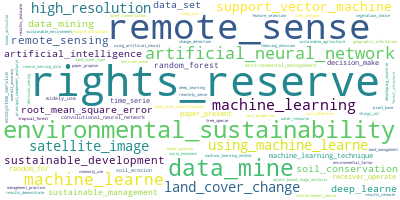

In [11]:
# Nuage de mots
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=100)
wordcloud.generate_from_frequencies(frequencies_ngram)
wordcloud.to_image()
# wordcloud.to_file("img/worldcloud.png")
wordcloud.to_image()

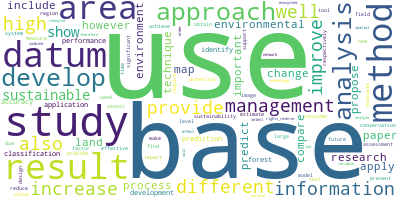

In [12]:
# Nuage de mots
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=100)
wordcloud.generate_from_frequencies(frequencies)
wordcloud.to_image()
# wordcloud.to_file("img/worldcloud.png")
wordcloud.to_image()

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"base" + 0.008*"sustainability" + 0.008*"design" + '
  '0.007*"environment" + 0.007*"datum" + 0.007*"technology" + '
  '0.007*"application" + 0.007*"research" + 0.007*"sustainable" + '
  '0.006*"approach"'),
 (1,
  '0.007*"response" + 0.006*"process" + 0.006*"control" + 0.006*"light" + '
  '0.005*"mechanism" + 0.005*"vehicle" + 0.005*"manufacturing" + '
  '0.005*"culture" + 0.004*"cut" + 0.004*"traffic"'),
 (2,
  '0.025*"use" + 0.012*"soil" + 0.011*"prediction" + 0.010*"base" + '
  '0.009*"method" + 0.008*"predict" + 0.007*"study" + 0.007*"datum" + '
  '0.006*"area" + 0.006*"high"'),
 (3,
  '0.027*"forest" + 0.016*"image" + 0.015*"tree" + 0.015*"classification" + '
  '0.013*"use" + 0.013*"map" + 0.009*"datum" + 0.008*"mapping" + 0.008*"study" '
  '+ 0.007*"landscape"'),
 (4,
  '0.020*"land" + 0.013*"change" + 0.012*"increase" + 0.010*"use" + '
  '0.010*"area" + 0.008*"study" + 0.007*"analysis" + 0.006*"result" + '
  '0.006*"urban" + 0.005*"base"')]


In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.821678164430149

Coherence Score:  0.40029330457577766


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LoL_topics.html')
vis

/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.132357  0.043392       1        1  29.522259
4     -0.075919 -0.088568       2        1  26.453808
0     -0.042602 -0.187183       3        1  26.140707
3     -0.062933  0.217316       4        1  12.945014
1      0.313811  0.015044       5        1   4.938213, topic_info=          Term        Freq       Total Category  logprob  loglift
44      forest  499.000000  499.000000  Default  30.0000  30.0000
1147      land  655.000000  655.000000  Default  29.0000  29.0000
559      image  357.000000  357.000000  Default  28.0000  28.0000
11      change  437.000000  437.000000  Default  27.0000  27.0000
900       soil  431.000000  431.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
291      plant   24.264268  111.447007   Topic5  -5.5492   1.4836
1102   machine   19.437763   55.751607   Topic5  -5.7710   1.9545
69         may   21.453675  129.350244   Topic5  -5.6723   1.2115
569   material   18.044741   77.549218   Topic5  -5.8453   1.5501
630     single   17.100736   63.981931   Topic5  -5.8991   1.6887

[336 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4138      1  0.989612  abandonment
1070      1  0.646148     accuracy
1070      2  0.026923     accuracy
1070      4  0.326920     accuracy
228       1  0.546557     accurate
...     ...       ...          ...
3213      4  0.978511         wood
131       1  0.220726         year
131       2  0.775693         year
1297      1  0.892648        yield
1297      2  0.101437        yield

[561 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 4, 2])

In [17]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = list(row)[0]
        row = sorted(row, key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
# dic_of_topic = {0:"Technique", 1:"Land", 2:"Energy", 3:"Meteo"}
# df_dominant_topic["Topic"] = df_dominant_topic["Dominant_Topic"].apply(lambda x: dic_of_topic[x])
df_dominant_topic


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.3847,"forest, image, tree, classification, use, map,...",Disturbance legacies and climate jointly drive...
1,1,3.0,0.6663,"forest, image, tree, classification, use, map,...",Mapping individual tree health using full-wave...
2,2,4.0,0.5182,"land, change, increase, use, area, study, anal...","Innovative Use of Sensors to Collect, Analyze ..."
3,3,3.0,0.6249,"forest, image, tree, classification, use, map,...","Do changes in spatial distribution, structure ..."
4,4,2.0,0.9846,"use, soil, prediction, base, method, predict, ...",Ensemble Wavelet-Support Vector Machine Approa...
...,...,...,...,...,...
1049,1049,4.0,0.6428,"land, change, increase, use, area, study, anal...",Combining CityGML files and data-driven models...
1050,1050,2.0,0.7357,"use, soil, prediction, base, method, predict, ...",Machine Learning for Gully Feature Extraction ...
1051,1051,4.0,0.8921,"land, change, increase, use, area, study, anal...",Scenarios of land use and land cover change fo...
1052,1052,3.0,0.5246,"forest, image, tree, classification, use, map,...",Update and spatial extension of strategic fore...


In [18]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

sent_topics_sorted = sent_topics_sorted.set_index("Topic_Num")
# Show
sent_topics_sorted.head(8)

,Topic_Perc_Contrib,Keywords,Text
Topic_Num,,,
0.0,0.9799,"base, sustainability, design, environment, dat...",Emerging Technologies for Sustainable Smart Ci...
1.0,0.9335,"response, process, control, light, mechanism, ...",Oxidized LDL-induced endolysosomal phospholipi...
2.0,0.9846,"use, soil, prediction, base, method, predict, ...",Ensemble Wavelet-Support Vector Machine Approa...
3.0,0.8334,"forest, image, tree, classification, use, map,...",Assessment of geostatistical features for obje...
4.0,0.9632,"land, change, increase, use, area, study, anal...",Land-use changes and policy dimension driving ...


In [19]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts*100/topic_counts.sum(), 4)
topic_counts

sent_topics_sorted = sent_topics_sorted.merge(topic_counts, how = "left", left_index=True, right_index = True)
sent_topics_sorted = sent_topics_sorted.merge(topic_contribution, how = "left", left_index = True, right_index = True)
sent_topics_sorted = sent_topics_sorted.rename(columns={"Dominant_Topic_x": "Articles", "Dominant_Topic_y": "Percentage"})
sent_topics_sorted

,Topic_Perc_Contrib,Keywords,Text,Articles,Percentage
Topic_Num,,,,,
0.0,0.9799,"base, sustainability, design, environment, dat...",Emerging Technologies for Sustainable Smart Ci...,306,29.0323
1.0,0.9335,"response, process, control, light, mechanism, ...",Oxidized LDL-induced endolysosomal phospholipi...,46,4.3643
2.0,0.9846,"use, soil, prediction, base, method, predict, ...",Ensemble Wavelet-Support Vector Machine Approa...,305,28.9374
3.0,0.8334,"forest, image, tree, classification, use, map,...",Assessment of geostatistical features for obje...,143,13.5674
4.0,0.9632,"land, change, increase, use, area, study, anal...",Land-use changes and policy dimension driving ...,254,24.0987


In [20]:
for i,j in sent_topics_sorted.Keywords.items():
    print(i,j)

0.0 base, sustainability, design, environment, datum, technology, application, research, sustainable, approach
1.0 response, process, control, light, mechanism, vehicle, manufacturing, culture, cut, traffic
2.0 use, soil, prediction, base, method, predict, study, datum, area, high
3.0 forest, image, tree, classification, use, map, datum, mapping, study, landscape
4.0 land, change, increase, use, area, study, analysis, result, urban, base


In [21]:
dic_of_topic = {0:"Soil and Water", 1:"Land Policy", 2:"Sustainable planning", 3:"Forest", 4:"Oil"}
df_dominant_topic["Topic"] = df_dominant_topic["Dominant_Topic"].apply(lambda x: dic_of_topic[x])
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Topic
0,0,3.0,0.3847,"forest, image, tree, classification, use, map,...",Disturbance legacies and climate jointly drive...,Forest
1,1,3.0,0.6663,"forest, image, tree, classification, use, map,...",Mapping individual tree health using full-wave...,Forest
2,2,4.0,0.5182,"land, change, increase, use, area, study, anal...","Innovative Use of Sensors to Collect, Analyze ...",Oil
3,3,3.0,0.6249,"forest, image, tree, classification, use, map,...","Do changes in spatial distribution, structure ...",Forest
4,4,2.0,0.9846,"use, soil, prediction, base, method, predict, ...",Ensemble Wavelet-Support Vector Machine Approa...,Sustainable planning
...,...,...,...,...,...,...
1049,1049,4.0,0.6428,"land, change, increase, use, area, study, anal...",Combining CityGML files and data-driven models...,Oil
1050,1050,2.0,0.7357,"use, soil, prediction, base, method, predict, ...",Machine Learning for Gully Feature Extraction ...,Sustainable planning
1051,1051,4.0,0.8921,"land, change, increase, use, area, study, anal...",Scenarios of land use and land cover change fo...,Oil
1052,1052,3.0,0.5246,"forest, image, tree, classification, use, map,...",Update and spatial extension of strategic fore...,Forest


In [22]:
result = pd.concat([df.reset_index(drop=True), df_dominant_topic.Dominant_Topic,df_dominant_topic.Topic,  df_dominant_topic.Keywords], axis=1)
result


,PT,AU,TI,LA,DE,AB,C1,PY,CN,TXT,Dominant_Topic,Topic,Keywords
0,J,"Bond-Lamberty, B; Rocha, AV; Calvin, K; Holmes...",Disturbance legacies and climate jointly drive...,English,boreal forest; carbon cycling; climate change;...,Most North American forests are at some stage ...,"[Bond-Lamberty, Ben; Calvin, Katherine] Univ M...",2014.0,"[United States, United States, United States, ...",Disturbance legacies and climate jointly drive...,3.0,Forest,"forest, image, tree, classification, use, map,..."
1,J,"Shendryk, I; Broich, M; Tulbure, MG; McGrath, ...",Mapping individual tree health using full-wave...,English,Tree health; Airborne laser scanning; Imaging ...,Declining forest health can affect crucial eco...,"[Shendryk, Iurii; Broich, Mark; Tulbure, Mirel...",2016.0,"[Australia, Australia, Australia, Australia, A...",Mapping individual tree health using full-wave...,3.0,Forest,"forest, image, tree, classification, use, map,..."
2,C,"Iakovoglou, V; Zaimes, GN; Emmanouloudis, D; I...","Innovative Use of Sensors to Collect, Analyze ...",English,sustainable agriculture; vineyards; Greece; st...,The main goal of all agricultural systems is t...,"[Iakovoglou, V.; Zaimes, G. N.; Emmanouloudis,...",2014.0,"[Greece, Greece, Greece]","Innovative Use of Sensors to Collect, Analyze ...",4.0,Oil,"land, change, increase, use, area, study, anal..."
3,J,"Ficko, A; Poljanec, A; Boncina, A","Do changes in spatial distribution, structure ...",English,Abies alba; Decline; Spatiotemporal dynamics; ...,Silver fir decline was investigated based on c...,"[Ficko, Andrej; Poljanec, Ales; Boncina, Andre...",2011.0,[Slovenia],"Do changes in spatial distribution, structure ...",3.0,Forest,"forest, image, tree, classification, use, map,..."
4,J,"Himanshu, SK; Pandey, A; Yadav, B",Ensemble Wavelet-Support Vector Machine Approa...,English,Support vector machine (SVM); Support vector m...,Explicit prediction of the suspended sediment ...,"[Himanshu, Sushil Kumar; Pandey, Ashish] India...",2017.0,"[India, India]",Ensemble Wavelet-Support Vector Machine Approa...,2.0,Sustainable planning,"use, soil, prediction, base, method, predict, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,J,"Chen, SS; Zhang, W; Wong, NH; Ignatius, M",Combining CityGML files and data-driven models...,English,CityGML; Data-driven model; Outdoor air temper...,This research first developed a solution to co...,"[Chen, Shisheng; Zhang, Wen; Wong, Nyuk Hien; ...",2020.0,[Singapore],Combining CityGML files and data-driven models...,4.0,Oil,"land, change, increase, use, area, study, anal..."
1050,J,"Phinzi, K; Abriha, D; Bertalan, L; Holb, I; Sz...",Machine Learning for Gully Feature Extraction ...,English,linear discriminant analysis; random forest; s...,Gullies reduce both the quality and quantity o...,"[Phinzi, Kwanele; Abriha, David] Univ Debrecen...",2020.0,"[Hungary, Hungary, Hungary]",Machine Learning for Gully Feature Extraction ...,2.0,Sustainable planning,"use, soil, prediction, base, method, predict, ..."
1051,J,"Armenteras, D; Murcia, U; Gonzalez, TM; Baron,...",Scenarios of land use and land cover change fo...,English,Land use land cover; Forest loss; Amazonia; Co...,Changes in land use and land cover (LULC) are ...,"[Armenteras, Dolors; Marisol Gonzalez, Tania] ...",2019.0,"[Colombia, Colombia]",Scenarios of land use and land cover change fo...,4.0,Oil,"land, change, increase, use, area, study, anal..."
1052,J,"Shang, C; Coops, NC; Wulder, MA; White, JC; He...",Update and spatial extension of strategic fore...,English,Species; Biomass; Volume; Land cover; Monitori...,Up-to-date forest inventory information relati...,"[Shang, Chen; Coops, Nicholas C.] Univ British...",2020.0,"[Canada, Canada]",Update and spatial extension of strategic fore...,3.0,Forest,"forest, image, tree, classification, use, map,..."


In [23]:
year_topic = result.groupby(["PY", "Topic"]).size()
year_topic = year_topic.unstack(1)
year_topic


Topic,Forest,Land Policy,Oil,Soil and Water,Sustainable planning
PY,,,,,
2010.0,2.0,NaN,9.0,8.0,9.0
2011.0,7.0,1.0,10.0,9.0,13.0
2012.0,8.0,4.0,9.0,5.0,6.0
2013.0,6.0,3.0,11.0,6.0,12.0
2014.0,9.0,2.0,11.0,12.0,7.0
2015.0,10.0,3.0,17.0,20.0,23.0
2016.0,5.0,5.0,15.0,21.0,21.0
2017.0,10.0,6.0,22.0,26.0,24.0
2018.0,22.0,9.0,34.0,39.0,40.0


<AxesSubplot:title={'center':'Life on Land over the years, five topics'}, xlabel='PY'>

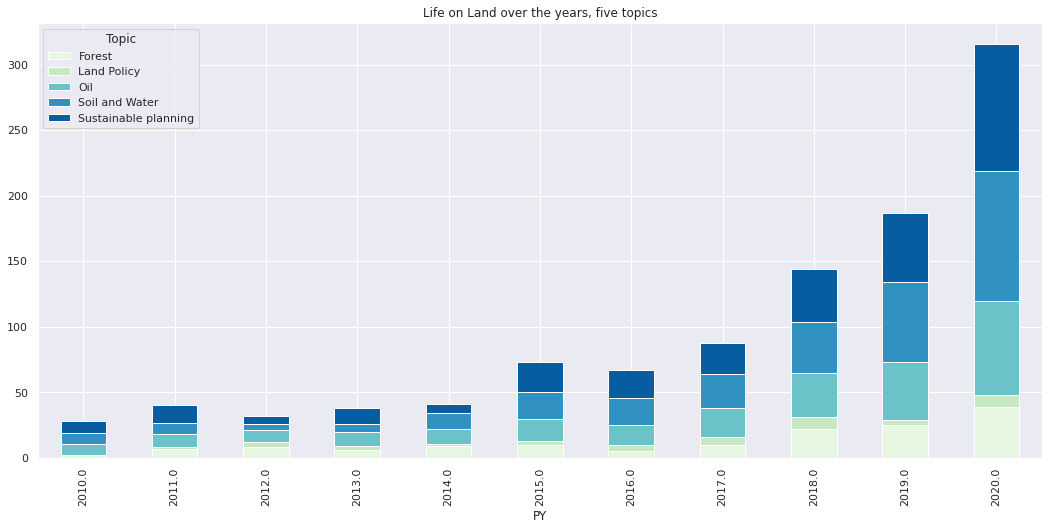

In [24]:
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set()
gr = year_topic.transpose().T.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), figsize=(18,8))
gr.set_title("Life on Land over the years, five topics")
gr.figure.savefig("LoL_5topics.png")
gr

In [25]:
year_topic_percentage = result.groupby(['PY']).Topic.value_counts(normalize=True).mul(100).unstack(1).transpose()
year_topic_percentage

PY,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
Topic,,,,,,,,,,,
Forest,7.142857,17.5,25.000,15.789474,21.951220,13.698630,7.462687,11.363636,15.277778,13.368984,12.341772
Land Policy,NaN,2.5,12.500,7.894737,4.878049,4.109589,7.462687,6.818182,6.250000,2.139037,2.848101
Oil,32.142857,25.0,28.125,28.947368,26.829268,23.287671,22.388060,25.000000,23.611111,23.529412,22.784810
Soil and Water,28.571429,22.5,15.625,15.789474,29.268293,27.397260,31.343284,29.545455,27.083333,32.620321,31.329114
Sustainable planning,32.142857,32.5,18.750,31.578947,17.073171,31.506849,31.343284,27.272727,27.777778,28.342246,30.696203


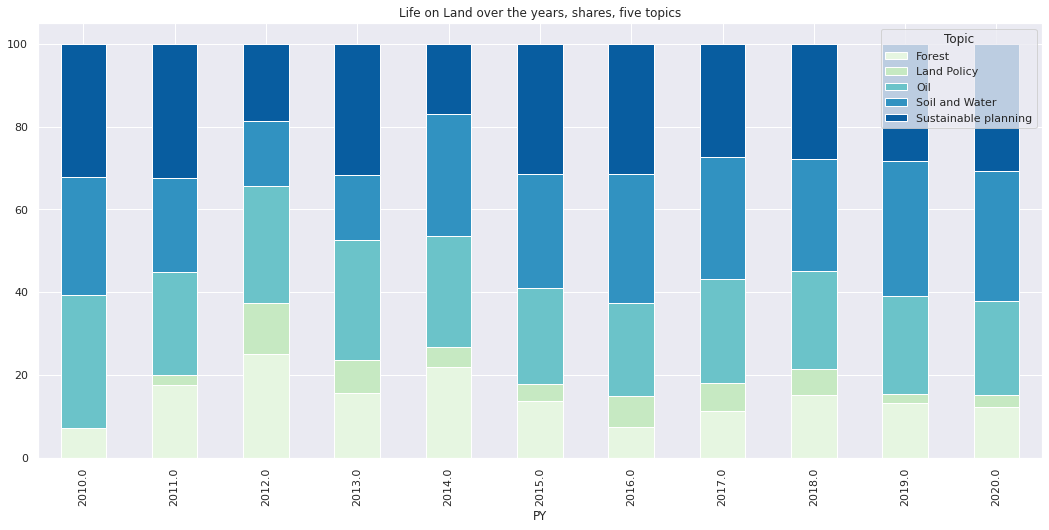

/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ke

In [26]:
gr = year_topic_percentage.T.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), figsize=(18,8))
gr.set(title="Life on Land over the years, shares, five topics")
gr.figure.savefig("LoL_5topics_share.png")